# Business Insight - Revenue

This notebook estimates revenues based on customer use and predicts revenues for the following year

## Introduction

The current pricing at Balena is shown in the picture. Each plan allows a given number of devices with a given number of team members. Extra devices or team members can be added for a price. 

<img src="files/pricing.png" width=700>

The dataset does not include which plan users have chosen. This could be inferred from the number of devices and team members, but the information about team members is not included either.

To estimate revenues some assumptions must necessarily be made. In our case we will choose to calculate an estimate that represents the *potential revenue* that could be had if each user picked their plan *according to the max number of devices*.

Assumptions:
- users with up to 10 devices in a given month are on a Free plan
- users with 11-20 devices in a given month are on Prototype plan
- users with 21-50 devices are on Pilot plan
- users with 51-100 devices are on Production plan
- users with more than 100 devices are on Enterprise plan

Although it is unrealistic that a single-user with 21 devices switches to a Pilot plan, nevertheless it is a possibility. This estimate represents therefore the upper limit for the revenue.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime, timedelta

## Monthly segmentation

Here we will proceed to calculate the max number of devices in each calendar month for each user

In [4]:
df = pd.read_csv('Active_Devices_per_user_per_day.csv',index_col=0, parse_dates=True)

In [5]:
year_list=df.index.year
month_list=df.index.month

In [6]:
# combine month and year to extract the max in each point
df['monthyear'] = [datetime(y,m,1) for (y,m) in zip(year_list,month_list)]

In [7]:
df.head()

1    2    3     4    5    6    7    8    9    10  ...  5447  \
2015-05-31  131.0  1.0  1.0  40.0  6.0  4.0  1.0  1.0  1.0   4.0  ...   0.0   
2015-06-01  130.0  1.0  0.0  42.0  6.0  4.0  1.0  1.0  1.0   6.0  ...   0.0   
2015-06-02  125.0  1.0  0.0  39.0  6.0  5.0  0.0  1.0  1.0   7.0  ...   0.0   
2015-06-03  121.0  1.0  0.0  42.0  6.0  5.0  0.0  1.0  1.0  11.0  ...   0.0   
2015-06-04  119.0  1.0  0.0  45.0  6.0  5.0  0.0  1.0  1.0  10.0  ...   0.0   

            5448  5449  5450  5451  5452  5453  5454  5455  monthyear  
2015-05-31   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 2015-05-01  
2015-06-01   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 2015-06-01  
2015-06-02   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 2015-06-01  
2015-06-03   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 2015-06-01  
2015-06-04   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 2015-06-01  

[5 rows x 5456 columns]

In [8]:
# monthly max devices per user
monthlymax=df.groupby('monthyear').max()

In [9]:
monthlymax.head()

1    2    3     4    5    6    7    8    9    10  ...  5446  \
monthyear                                                         ...         
2015-05-01  131.0  1.0  1.0  40.0  6.0  4.0  1.0  1.0  1.0   4.0  ...   0.0   
2015-06-01  130.0  1.0  0.0  61.0  6.0  6.0  1.0  1.0  2.0  13.0  ...   0.0   
2015-07-01   75.0  0.0  0.0  77.0  0.0  6.0  0.0  0.0  0.0  28.0  ...   0.0   
2015-08-01   49.0  0.0  0.0  78.0  0.0  7.0  0.0  1.0  1.0  27.0  ...   0.0   
2015-09-01   37.0  0.0  1.0  81.0  0.0  6.0  0.0  2.0  0.0  28.0  ...   0.0   

            5447  5448  5449  5450  5451  5452  5453  5454  5455  
monthyear                                                         
2015-05-01   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2015-06-01   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2015-07-01   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2015-08-01   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2015-09-01   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 5455 columns]

Now associate a pricing plan according to the max number of devices. Count the total number for each plan.

In [10]:
for k, (ind, row) in enumerate(monthlymax.iterrows()):
    # segment by product range
    seg = pd.cut(row,bins=[-1,0,10,20,50,100,1e6],
                             labels=['Inactive','Free','Prototype','Pilot','Production','Enterprise']).to_frame()
    seg.columns=['category']
    # aggregate
    segcat = seg.groupby('category')['category'].count().to_frame().transpose()
    # attach timestamp
    segcat.index = pd.date_range(ind,ind)
    if k==0:
        res = segcat
    else:
        res = pd.concat((res,segcat))

In [11]:
res.head()

category    Inactive  Free  Prototype  Pilot  Production  Enterprise
2015-05-01      5396    57          0      1           0           1
2015-06-01      5293   158          2      0           1           1
2015-07-01      5325   124          3      1           2           0
2015-08-01      5314   134          1      5           1           0
2015-09-01      5293   154          4      3           1           0

Number of paid plans vs. time

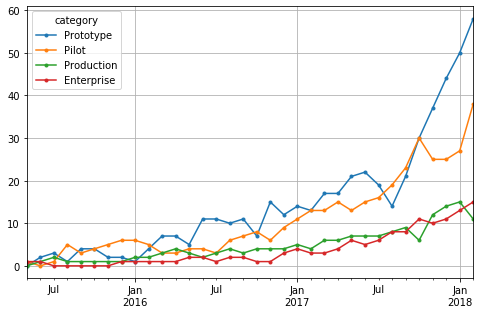

In [15]:
fig, ax = plt.subplots(figsize=(8,5));
res.plot.line(y=np.arange(2,6),marker='.',ax=ax);
plt.grid();

After an initial part where the curves are stable, there is a growing trend in each plan with a mild curvature. The curves can be well approximated by a second order polynomial.

## Extrapolation of plan quantities

In [21]:
# extract data from Feb 2016 only for paid plans
sub = res[res.index>='2016-02-01'][['Prototype','Pilot','Production','Enterprise']]
sub.head()

category    Prototype  Pilot  Production  Enterprise
2016-02-01          4      5           2           1
2016-03-01          7      3           3           1
2016-04-01          7      3           4           1
2016-05-01          5      4           3           2
2016-06-01         11      4           2           2

In [60]:
# numerical indices for the months chosen in sub
x = np.arange(0,len(sub))

In [66]:
# extension of numerical indices for another 12 months
xextra = np.arange(0,x[-1]+13,1)

Polynomial fit for all columns

In [73]:
for k in range(4):
    fint = np.polyfit(x, sub.iloc[:,k],deg=2)
    new_values = np.polyval(fint, xextra)
    # append values
    if k==0:
        data_fit = np.array([new_values])
    else:
        data_fit = np.concatenate((data_fit, np.array([new_values])))

Graphs of interpolation

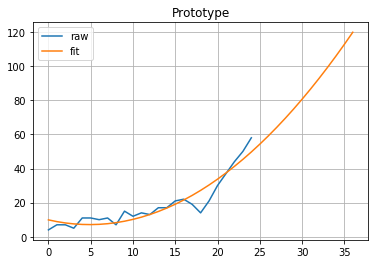

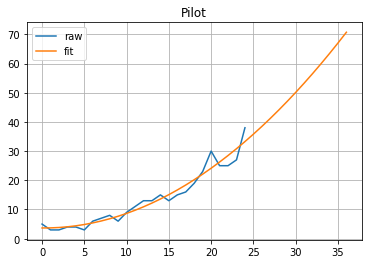

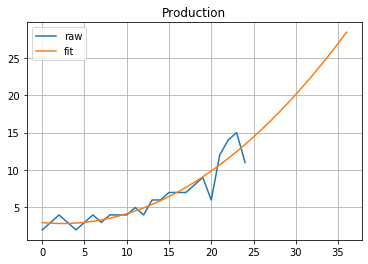

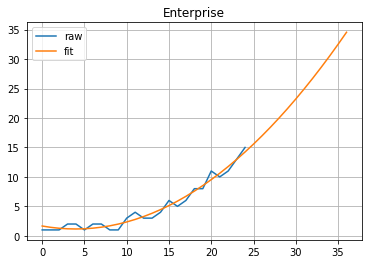

In [81]:
cl = sub.columns
for k in range(4):
    fig, ax = plt.subplots()
    ax.plot(x,sub.iloc[:,k],label='raw')
    ax.plot(xextra, data_fit[k,:],label='fit')
    ax.legend();
    plt.title(cl[k]);
    ax.grid();

The interpolation looks reasonable

In [116]:
# assemble results in a dataframe
fit_frame = pd.DataFrame(data=data_fit.T, columns = sub.columns.astype('object'),\
                        index = pd.date_range('2016/02/01','2019/02/01',freq='MS'))

## Revenue estimate

In [89]:
prices = pd.DataFrame(data=[99,299,1299,2999],index=sub.columns,columns=['price'])
prices

price
category         
Prototype      99
Pilot         299
Production   1299
Enterprise   2999

Revenue associated to the actual values stored in 'sub'

In [102]:
sub_revenue = pd.DataFrame(data= sub.values*prices.values.T, index=sub.index,\
                           columns= sub.columns.astype('object'))
sub_revenue['total'] = np.sum(sub_revenue,axis=1)
sub_revenue.head()

category    Prototype  Pilot  Production  Enterprise  total
2016-02-01        396   1495        2598        2999   7488
2016-03-01        693    897        3897        2999   8486
2016-04-01        693    897        5196        2999   9785
2016-05-01        495   1196        3897        5998  11586
2016-06-01       1089   1196        2598        5998  10881

Revenue associated to the fitted values stored in 'fit_frame'

In [120]:
fit_revenue = pd.DataFrame(data= fit_frame.values*prices.values.T, index=fit_frame.index,\
                           columns= fit_frame.columns)
fit_revenue['total'] = np.sum(fit_revenue,axis=1)
fit_revenue.head()

category     Prototype        Pilot   Production   Enterprise         total
2016-02-01  978.729231  1096.946667  3877.459487  4989.105641  10942.241026
2016-03-01  877.901538  1104.920000  3766.433846  4318.560000  10067.815385
2016-04-01  800.118662  1144.260000  3714.155251  3842.932642   9501.466555
2016-05-01  745.380602  1214.966667  3720.623701  3562.223567   9243.194537
2016-06-01  713.687358  1317.040000  3785.839197  3476.432776   9292.999331

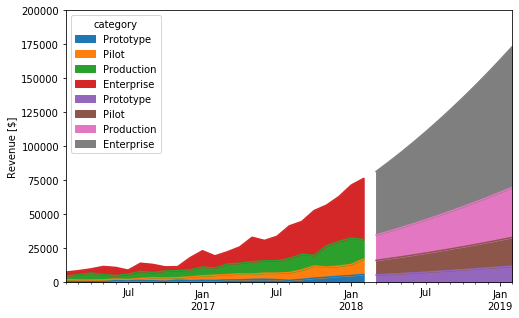

In [137]:
fig, ax = plt.subplots(figsize=(8,5));
sub_revenue.plot.area(y=np.arange(0,4),ax =ax);
fit_revenue.loc[fit_revenue.index>sub_revenue.index[-1]
               ].plot.area(y=np.arange(0,4),ax =ax);
plt.ylim(0,200e3);
plt.ylabel('Revenue [$]');

In dark colours the projection for the following year for each plan.